# Predicting Income
El objetivo de este trabajo es construir el siguiente modelo de salario horario individual:

$$
w = f(X) + u
$$  

Donde **w** es el salario horario y **X** es una matriz que contiene a las potenciales variables explicativas. Además, se lleva a cabo un modelo lineal tal que;

$$
ln(w) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p + u \tag{1}
$$  

Donde $ln(w)$ es el logaritmo del salario horario.

Para esto, se utiliza una muestra de Bogotá en el 2018 llamada _Medición de Pobreza Monetaria 
y Desigualdad Repor_ realizada por la Gran Encuesta Integrada de Hogares (GEIH).”


## Scrapeo de la muestra
Para obtener los datos pertinentes al estudio, se extrae información de la [página web](https://ignaciomsarmiento.github.io/GEIH2018_sample/) que contiene los microdatos de la encuesta. Este proceso se realiza utilizando **Beautiful Soup**. Ésta, es una biblioteca de Python que permite extraer datos de archivos HTML y XML.


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [4]:
# Crear una lista vacía para almacenar los datos de todas las páginas
all_data = []

# Iterar sobre las páginas 1 a 10
for i in range(1, 11):
    # Formatear la URL con el número de página
    url = f'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{i}.html'
    
    # Enviar el requerimiento HTTP a la página
    response = requests.get(url)
    
    # Comprobar si la respuesta fue exitosa (código de estado 200)
    if response.status_code == 200:
        # Parsear el contenido HTML de la página
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Aquí se asume que la información está en una tabla (ajusta esto según la estructura de tu página)
        table = soup.find('table')  # Encuentra la tabla en la página
        
        # Extraer las cabeceras de la tabla
        headers = [header.text.strip() for header in table.find_all('th')]
        
        # Extraer las filas de la tabla
        rows = table.find_all('tr')
        
        # Iterar sobre las filas y extraer los datos
        for row in rows:
            row_data = [cell.text.strip() for cell in row.find_all('td')]
            if row_data:  # Asegúrate de que la fila no esté vacía
                all_data.append(row_data)

# Convertir los datos extraídos en un DataFrame
df = pd.DataFrame(all_data, columns=headers)

# Mostrar el DataFrame
df

,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
0,1,4514331,1,2,1,BOGOTA,1,2,0,29,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125
2,3,4514332,1,4,1,BOGOTA,1,2,1,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,4514332,1,3,1,BOGOTA,1,2,1,7,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,4514332,1,1,1,BOGOTA,1,2,0,32,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NA,NA,NA,3345.5556640625,NA,NA,NA,NA,1003666.6875,3345.5556640625
32173,3214,4804455,1,1,1,BOGOTA,12,3,0,36,...,5e+05,NA,NA,25958.333984375,NA,NA,NA,NA,6675000,25958.333984375
32174,3215,4804455,1,2,1,BOGOTA,12,3,1,41,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
32175,3216,4804455,1,3,1,BOGOTA,12,3,1,8,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


La muestra inicial contiene 32.117 observaciones. Sin embargo, es necesario realizar una *limpieza* de la base de datos para filtrar las observaciones que son de interés.

## Limpieza de la base de datos
A continuación, se formula la muestra de interés. Se seleccionan solo los individuos mayores de 18 años de edad que reportan un ingreso positivo o no nulo.

In [7]:
# Se convierte la variable 'age' e ingreso a numérica
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['y_ingLab_m_ha'] = pd.to_numeric(df['y_ingLab_m_ha'], errors='coerce')

# Filtrado por individuos mayores de 18 años
df_filtrado = df[df['age'] > 18]

# Se convierten todas las columnas a numéricas excepto 'dominio'
df_filtrado = df_filtrado.copy()
for col in df_filtrado.columns:
    if col != 'dominio':
        df_filtrado[col] = pd.to_numeric(df_filtrado[col], errors='coerce')

# Se dropean valores faltantes (NaN) en 'y_ingLab_m_ha' y 'maxEducLevel'
df_sinmissings = df_filtrado.dropna(subset=['y_ingLab_m_ha', 'maxEducLevel'])

# Se dropean valores incoherentes (variable de interés mayor a 0)
df_final = df_sinmissings[df_sinmissings['y_ingLab_m_ha'] > 0]

df_final

,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NaN,NaN,NaN,8404.320312,NaN,NaN,NaN,NaN,1.620833e+06,8404.320312
8,9,4514333,1,1,1,BOGOTA,1,2,1,51,...,NaN,NaN,NaN,6703.342773,NaN,NaN,NaN,NaN,1.378973e+06,6703.342773
13,14,4514334,1,1,1,BOGOTA,1,2,1,45,...,NaN,NaN,NaN,3680.654053,NaN,NaN,NaN,NaN,8.833570e+05,3680.654053
15,16,4514335,1,1,1,BOGOTA,1,2,1,61,...,NaN,NaN,NaN,4083.333252,NaN,NaN,NaN,NaN,7.000000e+05,4083.333252
21,22,4514338,1,2,1,BOGOTA,1,2,0,35,...,NaN,NaN,NaN,9437.847656,NaN,NaN,NaN,NaN,1.941500e+06,9437.847656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32164,3205,4804453,1,6,1,BOGOTA,12,3,1,24,...,NaN,NaN,NaN,5288.888672,NaN,NaN,NaN,NaN,1.088000e+06,5288.888672
32166,3207,4804453,1,8,1,BOGOTA,12,3,0,50,...,NaN,NaN,NaN,4864.127441,NaN,NaN,NaN,NaN,1.146544e+06,4864.127441
32171,3212,4804454,1,1,1,BOGOTA,12,2,1,27,...,NaN,NaN,NaN,4453.359375,NaN,NaN,NaN,NaN,9.161197e+05,4453.359375
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NaN,NaN,NaN,3345.555664,NaN,NaN,NaN,NaN,1.003667e+06,3345.555664


In [8]:
import numpy as np
df_final = df_final.copy()
df_final['log_salario'] = np.log(df_final['y_ingLab_m_ha'])

## Descripción de la muestra 
A continuación, se muestran las **estadísticas descriptivas** de los datos y la composición de ésta según su edad, sexo, ubicación geográfica y nivel educativo.

In [10]:
# Lista de variables de interés
variables_interes = ['log_salario','age', 'sex', 'formal', 'college']

# Filtrar las columnas de interés y generar estadísticas descriptivas
df_descriptive_stats = df_final[variables_interes].describe(include='all')

# Mostrar las estadísticas descriptivas
df_descriptive_stats.T


,count,mean,std,min,25%,50%,75%,max
log_salario,9784.0,8.730900,0.726334,5.78894,8.349131,8.531453,8.999848,12.767354
age,9784.0,36.438369,11.937488,19.00000,27.000000,34.000000,45.000000,86.000000
sex,9784.0,0.501738,0.500023,0.00000,0.000000,1.000000,1.000000,1.000000
formal,9784.0,0.772792,0.419049,0.00000,1.000000,1.000000,1.000000,1.000000
college,9784.0,0.344031,0.475076,0.00000,0.000000,0.000000,1.000000,1.000000


Dada la tabla anterior, se puede afirmar que el salario promedio de esta economía es de $8.868, y una población de trabajadores mayores de edad, en promedio, 36 años de edad. Además, el 50.17% de la muestra está compuesta por trabajadores hombres, y el 70% del total de los trabajadores encuestados se encuentra en el sector formal. Por último, se tiene que el 34% de la muestra posee título terciario o universitario.

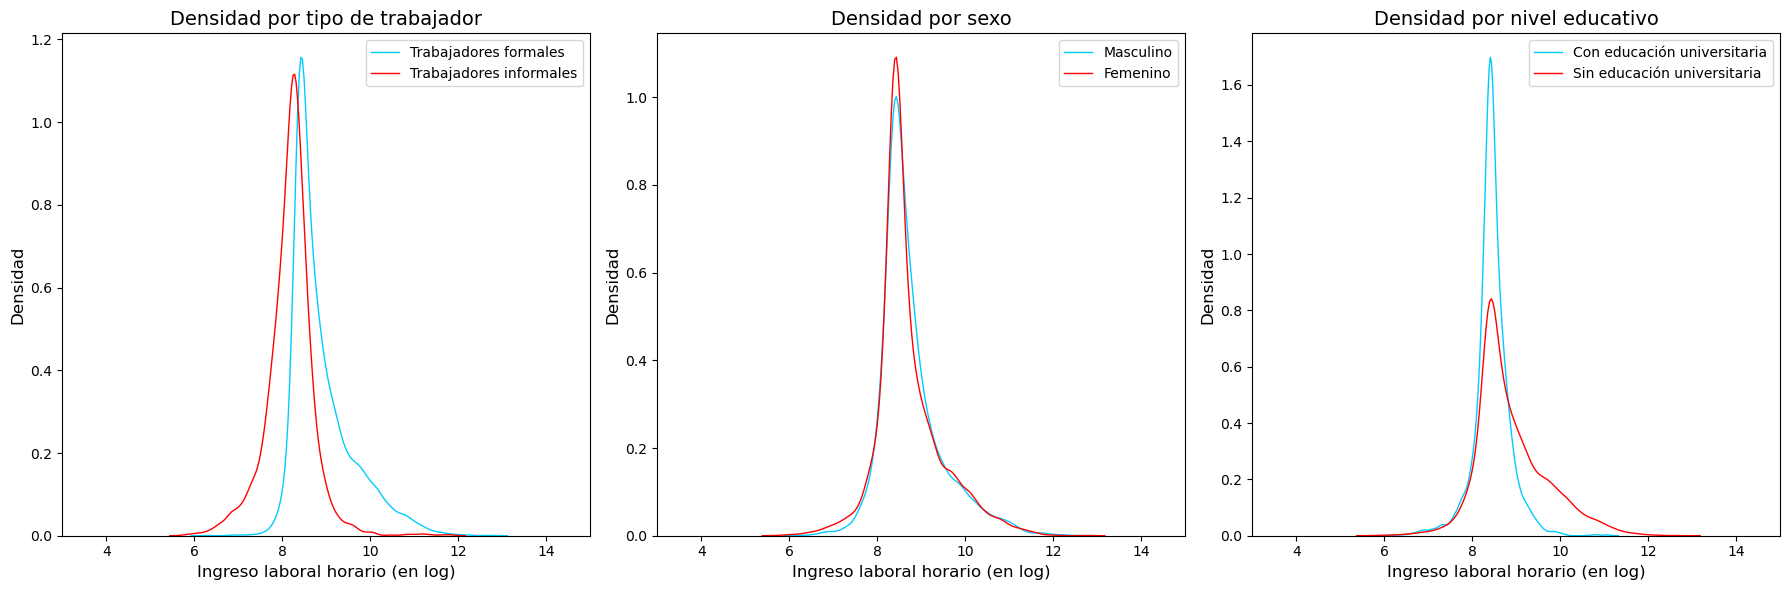

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ruta donde se guardarán los gráficos
ruta_destino = r'..\Views\grafico1.png'

plt.figure(figsize=(18, 6))

# Densidad del ingreso laboral por tipo de trabajador (formal vs informal)
plt.subplot(1, 3, 1)  
sns.kdeplot(
    data=df_final[df_final['formal'] == 1], 
    x='log_salario', 
    color='#00CDFF',  
    linewidth=1,  
    label='Trabajadores formales'
)
sns.kdeplot(
    data=df_final[df_final['formal'] == 0], 
    x='log_salario', 
    color='#FF0000', 
    linewidth=1, 
    label='Trabajadores informales'
)
plt.xlim(3, 15) 
plt.xlabel("Ingreso laboral horario (en log)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.title("Densidad por tipo de trabajador", fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)

# Densidad del ingreso laboral por sexo (1: masculino, 0: femenino)
plt.subplot(1, 3, 2) 
sns.kdeplot(
    data=df_final[df_final['sex'] == 1], 
    x='log_salario', 
    color='#00CDFF', 
    linewidth=1,  
    label='Masculino'
)
sns.kdeplot(
    data=df_final[df_final['sex'] == 0], 
    x='log_salario', 
    color='#FF0000', 
    linewidth=1,
    label='Femenino'
)
plt.xlim(3, 15)
plt.xlabel("Ingreso laboral horario (en log)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.title("Densidad por sexo", fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)

# Densidad del ingreso laboral por nivel educativo (college: 1 si tiene educación universitaria, 0 si no)
plt.subplot(1, 3, 3)  
sns.kdeplot(
    data=df_final[df_final['college'] == 1], 
    x='log_salario', 
    color='#00CDFF',  
    linewidth=1,
    label='Con educación universitaria'
)
sns.kdeplot(
    data=df_final[df_final['college'] == 0], 
    x='log_salario', 
    color='#FF0000',  
    linewidth=1,  
    label='Sin educación universitaria'
)
plt.xlim(3, 15)
plt.xlabel("Ingreso laboral horario (en log)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.title("Densidad por nivel educativo", fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)

# Se agrupan los tres gráficos
plt.tight_layout()

# Exportación de gráficos
plt.savefig(ruta_destino, format='png')

# Mostrar el gráfico
plt.show()


Los gráficos de función de densidad permiten observar que el ingreso laboral horario es, en promedio, mayor en los trabajadores formales que los informales. Además, la proporción de mujeres con un ingreso promedio es mayor que la de hombres, y esto se repite para los individuos con educación universitaria por sobre los que no la tienen, mostrando estos últimos una brecha mayor entre sí. 

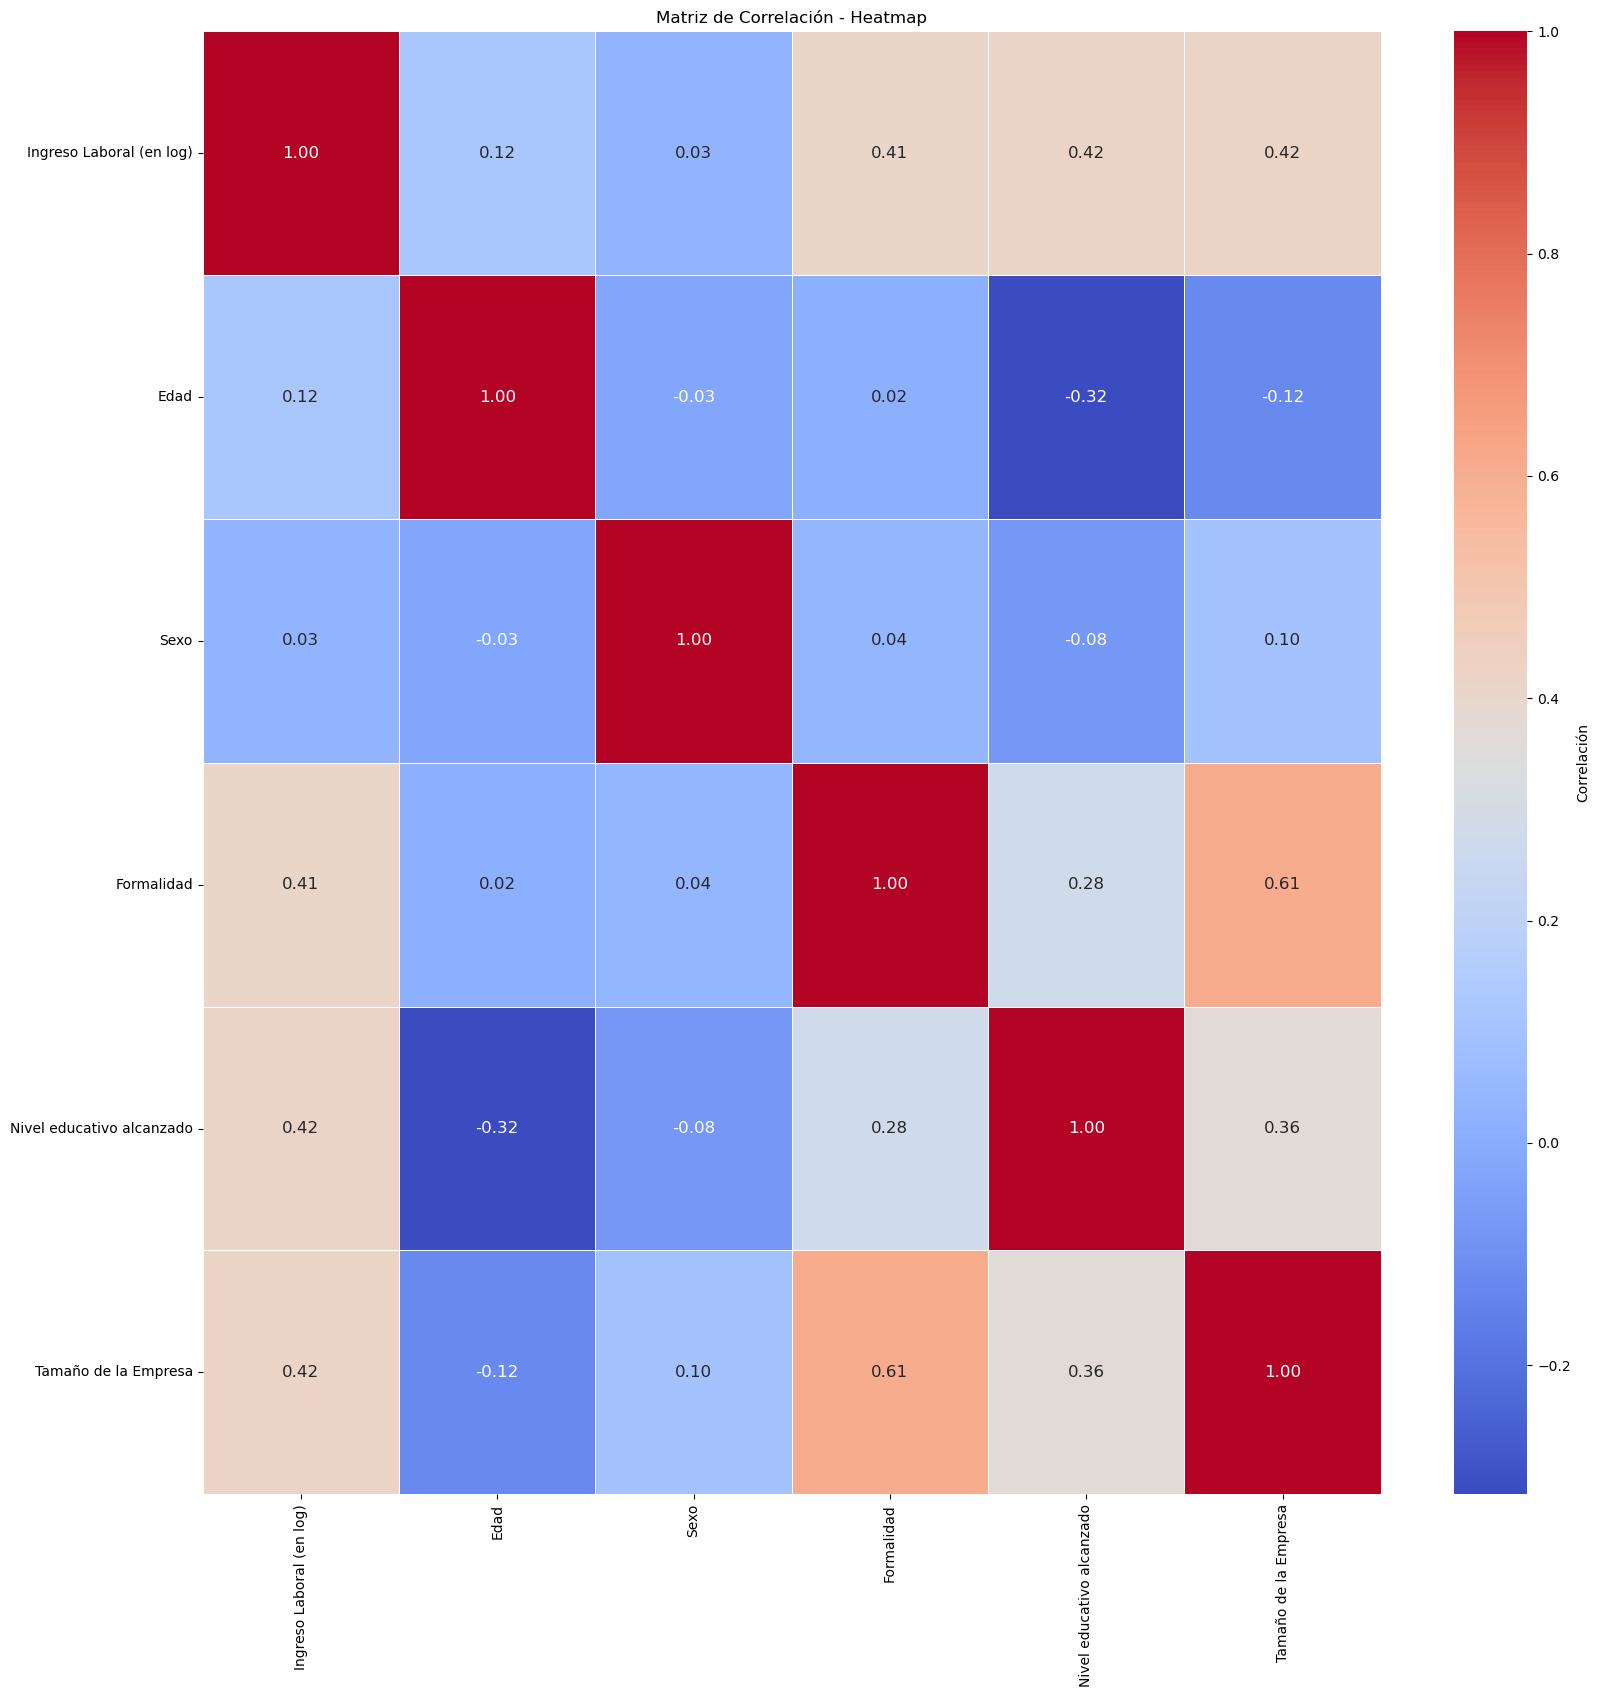

In [14]:
# Mapa de calor
ruta_destino = r'..\Views\grafico2.png'

# Variables de interés
variables_de_interes = ['log_salario', 'age', 'sex', 'formal', 'maxEducLevel', 'sizeFirm']
df_subset = df_final[variables_de_interes]

# Calcular la matriz de correlación
correlation_matrix = df_subset.corr()

# Renombrar las variables con etiquetas personalizadas
nuevas_etiquetas = {
    'log_salario': 'Ingreso Laboral (en log)',
    'age': 'Edad',
    'sex': 'Sexo',
    'formal': 'Formalidad',
    'maxEducLevel': 'Nivel educativo alcanzado',
    'sizeFirm': 'Tamaño de la Empresa'
}

# Aplicar los nuevos nombres de las variables
correlation_matrix = correlation_matrix.rename(index=nuevas_etiquetas, columns=nuevas_etiquetas)

# Crear el mapa de calor
plt.figure(figsize=(19, 19))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            cbar_kws={'label': 'Correlación'}, annot_kws={'size': 12})

# Ajustar la orientación de las etiquetas
plt.xticks(rotation=90)  # Etiquetas verticales para el eje X
plt.yticks(rotation=0)   # Etiquetas horizontales para el eje Y

# Título del gráfico
plt.title('Matriz de Correlación - Heatmap')

# Guardar el gráfico antes de mostrarlo
plt.savefig(ruta_destino, format='png')  # Guardar en formato PNG

# Mostrar el gráfico
plt.show()

La matriz de correlación permite ver las relaciones lineales entre diferentes variables de interés. En este caso, se observa la relación entre el logaritmo del ingreso laboral, edad, sexo, formalidad, nivel educativo alcanzado y tamaño de la empresa de los trabajadores. En particular, se destaca la relación positiva entre el ingreso laboral y el tamaño de la empresa, el nivel educativo y la formalidad laboral. Esto es coherente con lo que se espera dada la literatura económica.

# Predicting wages
En esta sección se analizan distintas especificaciones para predecir el ingreso laboral horario, utilizando técnicas de remuestreo para evaluar el desempeño de cada alternativa modelada.

Las **técnicas de remuestreo** sirven para evaluar el desempeño de un modelo ya que separan los datos y los contrastan. Una parte de los datos se utiliza para entrenar al modelo, y la otra parte sirve para evaluar la precisión de dicho modelo.

Este proceso se repite varias veces con diferentes subconjuntos de datos, y los resultados se promedian y se resumen. 

## Validation set approach
Este sera el primer enfoque implementado. En línea con el procedimiento usual de las técnicas de remuestreo, una porción fija de los datos se designa como el conjunto de validación, y el modelo se entrena con los datos restantes. Luego, el desempeño del modelo se evalúa utilizando el conjunto de validación.

Estas particiones se denominan:

**Muestra de entrenamiento:** para construir, estimar, entrenar el modelo.

**Muestra de prueba (validación, reserva)** para evaluar su desempeño.

In [18]:
# Se define el vector X: variables explicativas de la variable de Y

X = df_final[variables_de_interes]

y = df_final[['log_salario']]

Se genera un índice de muestra que indicará con **`TRUE`** aquellas observaciones asignadas de forma aleatoria al 
conjunto de datos de entrenamiento con un 70% de probabilidad, y con **`FALSE`** aquellas observaciones
asignadas aleatoriamente al conjunto de datos de prueba con un 30% de probabilidad.


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=0.3,
                                        train_size=0.7,
                                        random_state = 123
                                    )
X_train.head()

,log_salario,age,sex,formal,maxEducLevel,sizeFirm
7741,8.673961,43,1,1.0,6.0,5.0
22475,8.500072,32,1,1.0,7.0,5.0
13596,8.017417,19,0,0.0,7.0,5.0
31707,8.357765,29,0,1.0,6.0,5.0
15334,8.349131,19,1,0.0,6.0,2.0


Una vez particionadas las muestras, se pueden construir los diversos modelos predictivos. En primer lugar, se estima el modelo simple sin covariables.

### Modelo 1

En este caso, la predicción del logaritmo del salario laboral será:

$$
\hat{y} = \hat{\beta}_1 = \frac{\sum y_i}{n} = m
$$

In [23]:
# Se importan librerías que nos permitirán correr las regresione más adelante
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X0 = np.ones((len(y_train), 1))
model1=  LinearRegression().fit(X0,y_train)
model1.intercept_

array([8.73424241])

In [24]:
y_train.mean()

log_salario    8.734242
dtype: float64

Para testear la predicción de los valores fuera de la muestra, hay que evaluar este modelo en la muestra de prueba. Con este objetivo, se utiliza el coeficiente estimado en la muestra de entrenamiento y se lo utiliza como predictor de los datos de prueba.

In [26]:
# Predicción de la nueva data
X0_test = np.ones((len(y_test), 1))
y_hat_model1 = model1.predict(X0_test)

Luego podemos calcular el rendimiento del modelo utilizando el MSE. Esto es,
$$
test MSE = E[(y - \hat{y})^2]
$$

In [28]:
from sklearn.metrics import mean_squared_error

# Se calcula el Mean Squared Error
mse1 = mean_squared_error(y_test, y_hat_model1)

print(f'\nMean Squared Error: {mse1}\n')


Mean Squared Error: 0.5405209795486049



Para mejorar la predicción del modelo, se incorporarán sucesivas variables explicativas para testear el ingreso laboral horario bajo distintas especificaciones. 

### Modelo 2
Se adiciona la primera covariable: la edad.

In [31]:
# Se crea el modelo de regresión lineal
model2=  LinearRegression().fit(X_train[['age']],y_train)
model2.coef_

# Predicción de la nueva data
y_hat_model2 = model2.predict(X_test[['age']])

# Se calcula el Mean Squared Error
mse2 = mean_squared_error(y_test, y_hat_model2)
print(f'\nMean Squared Error: {mse2}\n')


Mean Squared Error: 0.535473435562669



La literatura empírica muestra que la relación entre la edad y en nivel de ingreso no es una relación lineal. Es más bien una relación de "U invertida" en donde los ingresos labolares al inicio de la vida de un individuo son nulos y van progresivamente aumentando durante los años activos económicamente, para luego volver a retraerse cuando se llega a la vejez. 

Por esto, una simple regresión lineal entre el logaritmo del salario y la edad no demuestra gran potencial explicativo. Como alternativa, se incluirá a continuación la edad$^2$ para capturar esta relación no lineal.

### Modelo 3
Este modelo incluye la edad y su cuadrado como variables explicativas

In [34]:
# Se crea la variable de edad al cuadrado
X_train['age_squared'] = X_train['age'] ** 2
X_test['age_squared'] = X_test['age'] ** 2

# Se crea el modelo de regresión lineal
model3 = LinearRegression().fit(X_train[['age', 'age_squared']], y_train)

# Predicción de la nueva data
y_hat_model3 = model3.predict(X_test[['age', 'age_squared']])

# Se calcula el Mean Squared Error
mse3 = mean_squared_error(y_test, y_hat_model3)
print(f'\nMean Squared Error: {mse3}\n')


Mean Squared Error: 0.5196417261404243



### Modelo 4

Este modelo incluye la edad, edad al cuadrado, y el máximo nivel educativo alcanzado por un trabajador mayor de 18 años para explicar el logaritmo del salario.

In [36]:
# Se crea el modelo de regresión lineal
model4 = LinearRegression().fit(X_train[['age', 'age_squared', 'maxEducLevel']], y_train)

# Predicción de la nueva data
y_hat_model4 = model4.predict(X_test[['age', 'age_squared', 'maxEducLevel']])

# Se calcula el Mean Squared Error
mse4 = mean_squared_error(y_test, y_hat_model4)
print(f'\nMean Squared Error: {mse4}\n')


Mean Squared Error: 0.3955262823223256



### Modelo 5
Este modelo incluye todas las variables incluidas hasta ahora y se adiciona la covariable _sexo_.

In [38]:
# Se crea el modelo de regresión lineal
model5 = LinearRegression().fit(X_train[['age', 'age_squared', 'maxEducLevel', 'sex']], y_train)

# Predicción de la nueva data
y_hat_model5 = model5.predict(X_test[['age', 'age_squared', 'maxEducLevel', 'sex']])

# Se calcula el Mean Squared Error
mse5 = mean_squared_error(y_test, y_hat_model5)
print(f'\nMean Squared Error: {mse5}\n')


Mean Squared Error: 0.3917813458964586



Tanto en este modelo como en el anterior se aprecia cómo a medida que se agregan regresores en el modelo, la estimación mejora. Por lo tanto, se continúa adicionando variables explicativas.

### Modelo 6
Este modelo incluye todas las variables incluidas anteriormente, más un nuevo regresor, la variable _formal_ que vale 1 si el individuo trabaja en el sector formal.

In [41]:
# Se crea el modelo de regresión lineal
model6 = LinearRegression().fit(X_train[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal']], y_train)

# Predicción de la nueva data
y_hat_model6 = model6.predict(X_test[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal']])

# Se calcula el Mean Squared Error
mse6 = mean_squared_error(y_test, y_hat_model6)
print(f'\nMean Squared Error: {mse6}\n')


Mean Squared Error: 0.3555724820973047



### Modelo 7
Esta nueva especificación incluye las variables anteriores, más un regresor que contempla el tamaño de la firma en la que trabaja el individuo

In [43]:
# Se crea el modelo de regresión lineal
model7 = LinearRegression().fit(X_train[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm']], y_train)

# Predicción de la nueva data
y_hat_model7 = model7.predict(X_test[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm']])

# Se calcula el Mean Squared Error
mse7 = mean_squared_error(y_test, y_hat_model7)
print(f'\nMean Squared Error: {mse7}\n')


Mean Squared Error: 0.3419982723923278



### Modelo 8 
Este nuevo modelo contempla todos los regresores anteriores y la condición de jefe de hogar del trabajador. 

In [45]:
# Se agrega la dummy 'jefedehogar' que vale 1 cuando el trabajador se reconoce como jefe de hogar.
X_train['jefedehogar'] = (df_final.loc[X_train.index, 'p6050'] == 'jefe de hogar').astype(int)
X_test['jefedehogar'] = (df_final.loc[X_test.index, 'p6050'] == 'jefe de hogar').astype(int)

# Se crea el modelo de regresión lineal
model8 = LinearRegression().fit(
    X_train[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'jefedehogar']],
    y_train
)

# Predicción de la nueva data
y_hat_model8 = model8.predict(
    X_test[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'jefedehogar']]
)

# Calcular el Mean Squared Error
mse8 = mean_squared_error(y_test, y_hat_model8)
print(f'\nMean Squared Error: {mse8}\n')



Mean Squared Error: 0.34199827239232783



Vemos que el modelo empeora levemente su estimación. Podemos estar comenzando a incurrir en una _sobreparametrización_.

### Modelo 9
La literatura dedicada a la economía laboral postula que un mayor ingreso no laboral atenta contra la oferta de trabajo tanto en margen extensivo como en margen intensivo. Para testear si el ingreso no laboral es una variable relevante en la explicación del salario, se incorpora una _dummy_ que vale 1 cuando el individuo percibe algún tipo de ayuda estatal.

In [48]:
# Se crea la dummy 'ing_no_laboral' que vale 1 si alguna de las variables p6585s1, p6585s2, p6585s3, p6585s4 vale 1
df_final['ing_no_laboral'] = (
    (df_final['p6585s1'] == 1) | 
    (df_final['p6585s2'] == 1) | 
    (df_final['p6585s3'] == 1) | 
    (df_final['p6585s4'] == 1)
).astype(int)

# Agregar 'ing_no_laboral' a X_train y X_test
X_train['ing_no_laboral'] = (df_final.loc[X_train.index, 'ing_no_laboral']).astype(int)
X_test['ing_no_laboral'] = (df_final.loc[X_test.index, 'ing_no_laboral']).astype(int)

# Se crea el modelo de regresión lineal
model9 = LinearRegression().fit(
    X_train[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral']],
    y_train
)

# Predicción de la nueva data
y_hat_model9 = model9.predict(
    X_test[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral']]
)

# Calcular el Mean Squared Error
mse9 = mean_squared_error(y_test, y_hat_model9)
print(f'\nMean Squared Error: {mse9}\n')



Mean Squared Error: 0.28872259441582077



¡El modelo mejora sustancialmente!

### Modelo 10
Por último, se incluyen interacciones de ciertas variables incluidas en el modelo 9, que resultó el más eficiente hasta ahora.

In [51]:
# Se crean las interacciones
X_train['maxEducLevel_sex'] = X_train['maxEducLevel'] * X_train['sex']
X_test['maxEducLevel_sex'] = X_test['maxEducLevel'] * X_test['sex']

X_train['sex_formal'] = X_train['sex'] * X_train['formal']
X_test['sex_formal'] = X_test['sex'] * X_test['formal']

# Se crea el modelo de regresión lineal
model10 = LinearRegression().fit(
    X_train[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral', 'maxEducLevel_sex', 'sex_formal']],
    y_train
)

# Predicción de la nueva data
y_hat_model10 = model10.predict(
    X_test[['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral', 'maxEducLevel_sex', 'sex_formal']]
)

# Calcular el Mean Squared Error
mse10 = mean_squared_error(y_test, y_hat_model10)
print(f'\nMean Squared Error: {mse10}\n')



Mean Squared Error: 0.2877869198993724



### Análisis de los errores

In [53]:
# Resumen de los resultados
mse_values = {
    'Model': [f'Model {i}' for i in range(1, 11)],
    'MSE': [mse1, mse2, mse3, mse4, mse5, mse6, mse7, mse8, mse9, mse10]
}

mse_df = pd.DataFrame(mse_values)
styled_df = mse_df.style.set_table_styles(
    [{
        'selector': 'thead th', 
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, 
    {
        'selector': 'tbody tr:nth-child(even)', 
        'props': [('background-color', '#f2f2f2')]
    }]
)

styled_df


,Model,MSE
0,Model 1,0.540521
1,Model 2,0.535473
2,Model 3,0.519642
3,Model 4,0.395526
4,Model 5,0.391781
5,Model 6,0.355572
6,Model 7,0.341998
7,Model 8,0.341998
8,Model 9,0.288723
9,Model 10,0.287787


El modelo 10 muestra los errores más pequeños. Se profundizará en los errores de este modelo y las observaciones que podrían estar _missing the mark_.

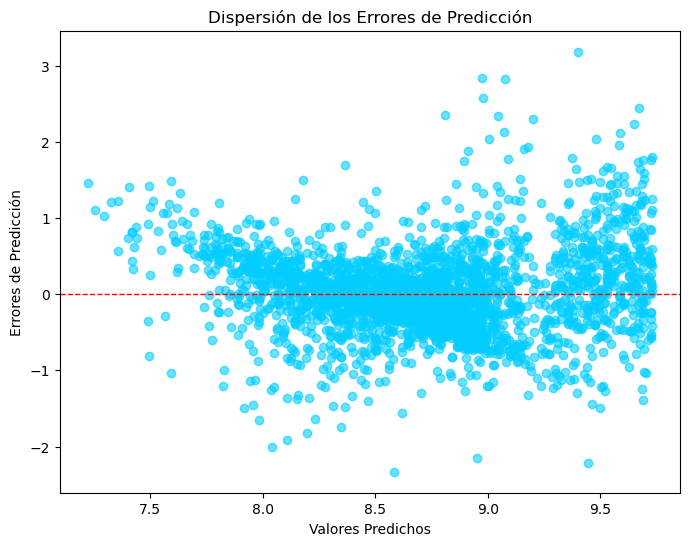

In [55]:
# Cálculo del desvío 
errors = y_test - y_hat_model10

ruta_destino = r'..\Views\grafico3.png'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_hat_model10, errors, alpha=0.6, color="#03CDFF")
plt.axhline(0, color="red", linestyle="--", linewidth=1)  # Línea de referencia en y=0
plt.title("Dispersión de los Errores de Predicción")
plt.xlabel("Valores Predichos")
plt.ylabel("Errores de Predicción")

plt.savefig(ruta_destino, format='png') 
plt.show()

Hay indicios de algunos _outliers_. Se muestra a continuación las observaciones dentro del **percentil 1** y el **percentil 99** de la muestra.

In [57]:
# Umbrales basados en los percentiles 1 y 99
lower_bound = np.percentile(errors, 1)
upper_bound = np.percentile(errors, 99)

# Observaciones en los extremos
outliers = X_test[(errors < lower_bound) | (errors > upper_bound)]
outliers
data_filtrada = (errors >= lower_bound) & (errors <= upper_bound)

# Crear nuevas muestras sin outliers
X_train_no_outliers = X_train[data_filtrada]
y_train_no_outliers = y_train[data_filtrada]
X_test_no_outliers = X_test[data_filtrada]
y_test_no_outliers = y_test[data_filtrada]

# Verificar cuántas observaciones quedan
print(f"Muestra sin outliers:\n{X_train_no_outliers.shape[0]} observaciones.")

Muestra sin outliers:
6848 observaciones.


Se observan 2936 _outliers_, principamente compuestos por _missings_. Se muestra a continuación la **dispersión** de estos valores registrados.

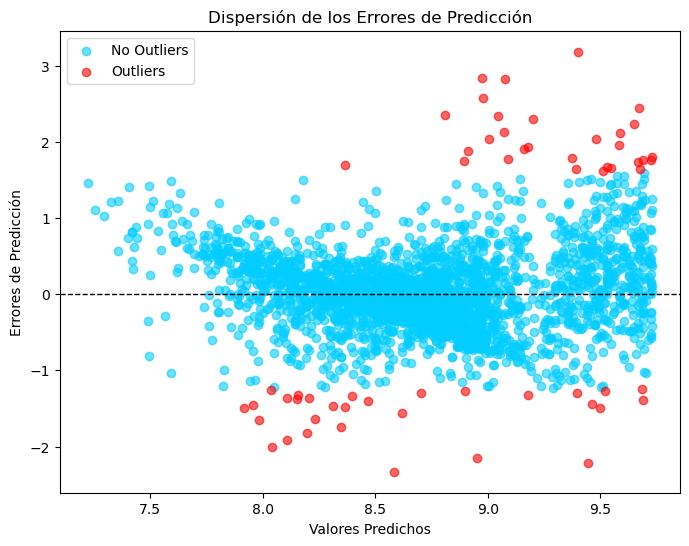

In [59]:
# Para poder recalcular el modelo, las variables deben ser numpy arrays.
y_test = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
y_hat_model10 = y_hat_model10.values if isinstance(y_hat_model10, pd.DataFrame) else y_hat_model10

errors = y_test - y_hat_model10

# Marcar los outliers (puntos dentro de los percentiles 5 y 95)
outliers_mask = (errors >= lower_bound) & (errors <= upper_bound)

# Datos para los puntos
predicted_inliers = y_hat_model10[outliers_mask].flatten() 
errors_inliers = errors[outliers_mask].flatten()  

predicted_outliers = y_hat_model10[~outliers_mask].flatten() 
errors_outliers = errors[~outliers_mask].flatten() 

ruta_destino = r'..\Views\grafico4.png'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))

# Puntos inliers (no outliers) en azul
plt.scatter(predicted_inliers, errors_inliers, alpha=0.6, color="#03CDFF", label="No Outliers")

# Puntos outliers en rojo
plt.scatter(predicted_outliers, errors_outliers, alpha=0.6, color="#FF0000", label="Outliers")

plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Dispersión de los Errores de Predicción")
plt.xlabel("Valores Predichos")
plt.ylabel("Errores de Predicción")
plt.legend()

plt.savefig(ruta_destino, format='png')
plt.show()

## Leave one out cross validation
Con el objetivo de testear la robustez del análisis, se emplea una técnica de validación cruzada _leave one out_.  En esta metodología, en lugar de dividir el conjunto de datos en varios subconjuntos, el modelo se entrena utilizando todos los puntos de datos excepto uno, y luego se prueba sobre ese único punto de prueba.

In [61]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Se definen los modelos con sus respectivas especificaciones de columnas
model_specs = {
    'model9': ['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral'],
    'model10': ['age', 'age_squared', 'maxEducLevel', 'sex', 'formal', 'sizeFirm', 'ing_no_laboral', 'maxEducLevel_sex', 'sex_formal']
}

# Inicializar LeaveOneOut
loo = LeaveOneOut()

# Diccionario para almacenar los resultados
rmse_results = {}

# Loop para iterar sobre cada modelo
for model_name, columns_to_use in model_specs.items():
    # Se filtran las columnas de interés y se definen X e Y
    columns_present = [col for col in columns_to_use if col in df_final.columns]
    X = df_final[columns_present]
    y = df_final['log_salario']  

    # Preprocesamiento: se normalizan las variables numéricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), columns_present)  # Se utilizan solo las columnas de interés
        ],
        remainder='passthrough'
    )

    # Una vez más, se crea el modelo de regresión lineal
    model = LinearRegression()

    # Crear un pipeline con el preprocesador y el modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Listas para almacenar los resultados del MSE
    mse_list = []

    # Realizar LOOCV
    for train_index, test_index in loo.split(X):
        # Dividir los datos en train y test según los índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Se ajusta el modelo en el conjunto de entrenamiento
        pipeline.fit(X_train, y_train)

        # Predicción
        y_pred = pipeline.predict(X_test)

        # Predicción de la data
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # Se calcula el RMSE promedio para este modelo
    rmse_loocv = np.sqrt(np.mean(mse_list))
    rmse_results[model_name] = rmse_loocv

# Mostrar los resultados
for model_name, rmse in rmse_results.items():
    print(f'{model_name} - LOOCV RMSE: {rmse}')

model9 - LOOCV RMSE: 0.5403800271076717
model10 - LOOCV RMSE: 0.5403800271076717
